## Federal University of Bahia (UFBA)

### Control Systems Projects

### Challenge 03 - Sample Control System

### Professor: Tito Maia

### Student: Gabriel Correia

---


#### **OBSERVAÇÃO INICIAL**

Esse código ficou muito complicado, por isso, em cada item, eu copio basicamente tudo do anterior para mudar e simular de novo. Tinha forma mais inteligente de fazer isso aqui.


## Importanto Bibliotecas

In [2]:
!pip install control

!pip install numpy matplotlib control scipy


In [3]:
# Importando as bibliotecas para trabalhar como se fosse no MATLAB

import numpy as np
import matplotlib.pyplot as plt
import control as ct
from scipy.linalg import solve

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
import sys
import subprocess

# Tenta importar a biblioteca de controle e a instala se não estiver presente
try:
    import control as ct
except ImportError:
    print("Biblioteca 'control' não encontrada. Tentando instalar...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "control"])
        import control as ct
        print("Biblioteca 'control' instalada com sucesso. Rodando o script...")
    except Exception as e:
        print(f"Falha ao instalar a biblioteca 'control'. Erro: {e}")
        print("Por favor, instale a biblioteca manualmente executando: pip install control")
        sys.exit()

## Simulação

### *Baseando-me no livro "Discrete-Time Control Systems" de Katsuhiko Ogata*

A escolha do período de amostragem (Ta) deve garantir que o controlador digital tenha informações suficientes sobre a dinâmica do processo para atuar de forma eficaz, sem sobrecarregar o processador com uma taxa de amostragem desnecessariamente alta.

Uma regra prática consolidada, mencionada em obras clássicas de controle como "Discrete-Time Control Systems" de Katsuhiko Ogata, sugere que a frequência de amostragem (ωs) deve ser de 10 a 25 vezes maior que a frequência de canto ou a largura de banda da malha fechada (ωb).

ωs ≈ (10 a 25)⋅ωb

Em termos de período de amostragem (Ta=2π/ωs) e tempo de acomodação (ts), isso se traduz em ter aproximadamente de 10 a 25 amostras durante o tempo de acomodação da malha fechada (ts_cl). Essa abordagem garante que o controlador "veja" a resposta transitória do sistema com resolução suficiente para controlá-la adequadamente.

## VERSÃO 8 - DESAFIO III

=== SOLUÇÃO DEFINITIVA DESAFIO III ===

Ta calculado: 0.2965s
5 states have been removed from the model

--- [Q3] Alocação de Polos (Tau=0.8s) ---
R: [ 1.     -1.4349  0.4349]
S: [ 0.739  -1.0964  0.4066]
T: [ 0.739  -1.0964  0.4066]

Função de Transferência do Controlador C(z) = S(z)/R(z):
<TransferFunction>: sys[466]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.29654504985529373

  0.739 z^2 - 1.096 z + 0.4066
  ----------------------------
     z^2 - 1.435 z + 0.4349
5 states have been removed from the model

--- [Q4] IMC (Tau=0.5s) ---
R: [ 1.     -1.2104  0.2104]
S: [ 1.5959 -2.3675  0.878 ]
T: [ 1.5959 -2.3675  0.878 ]

Função de Transferência do Controlador C(z) = S(z)/R(z):
<TransferFunction>: sys[486]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.29654504985529373

  1.596 z^2 - 2.368 z + 0.878
  ---------------------------
     z^2 - 1.21 z + 0.2104


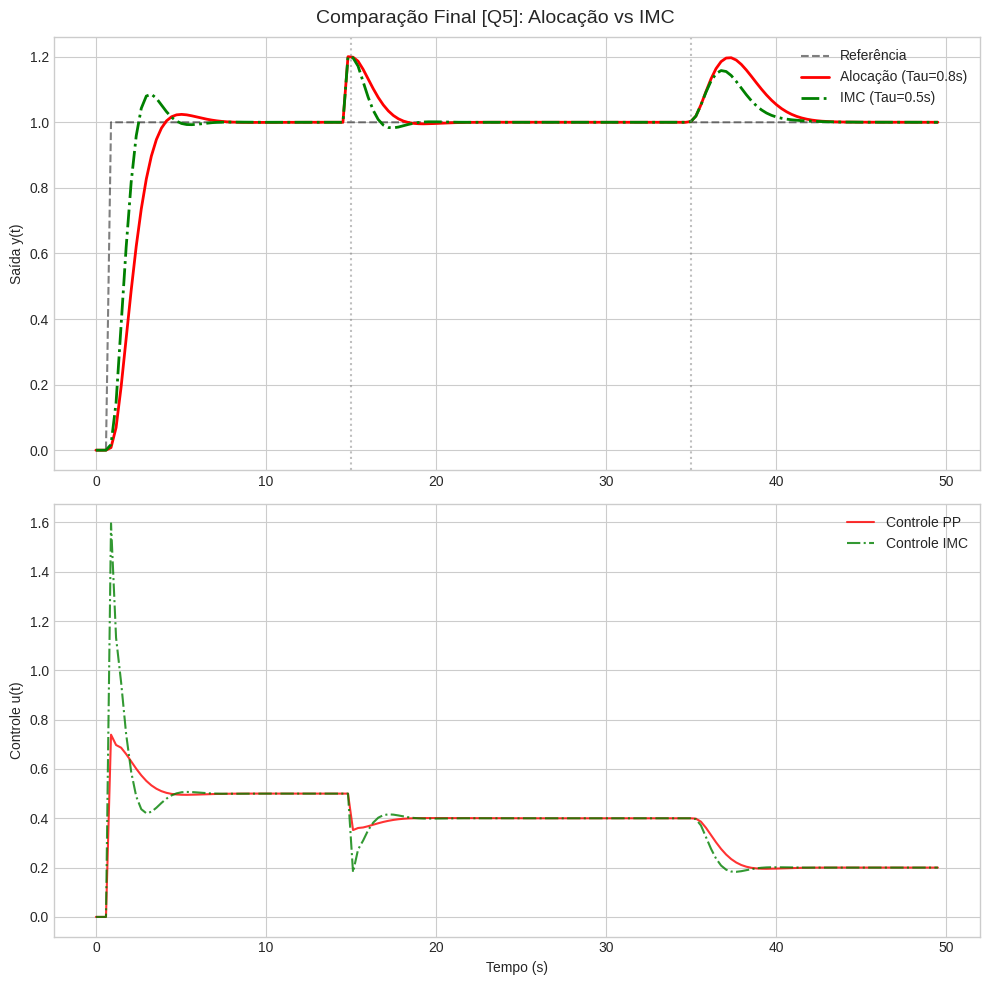

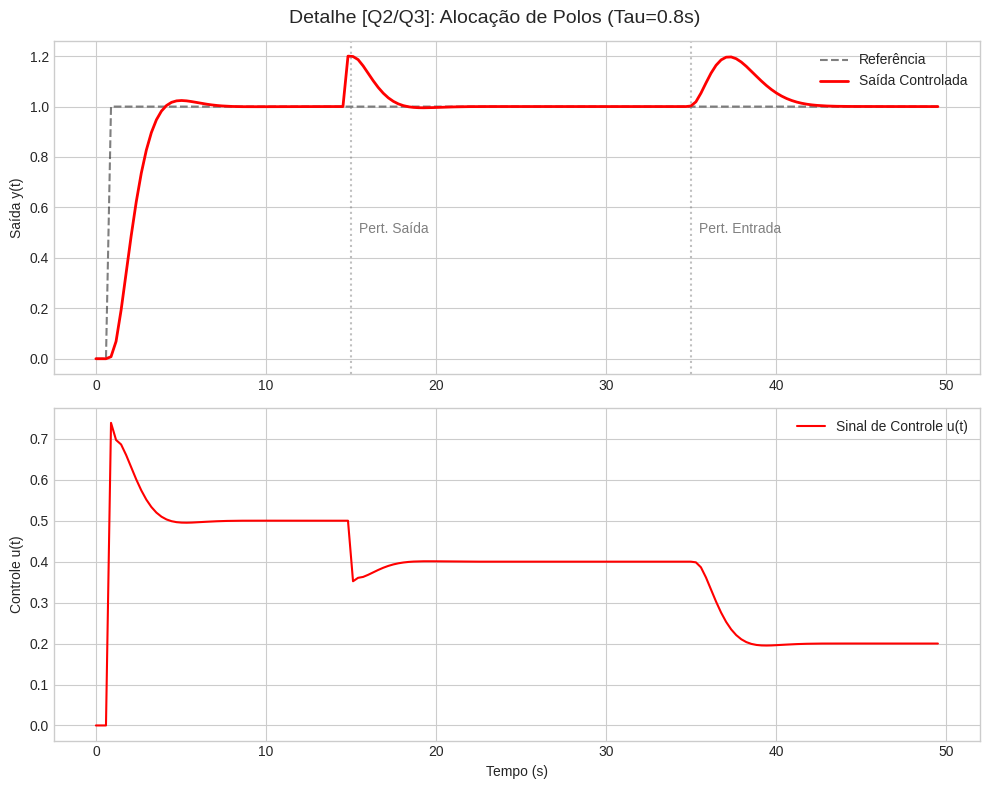

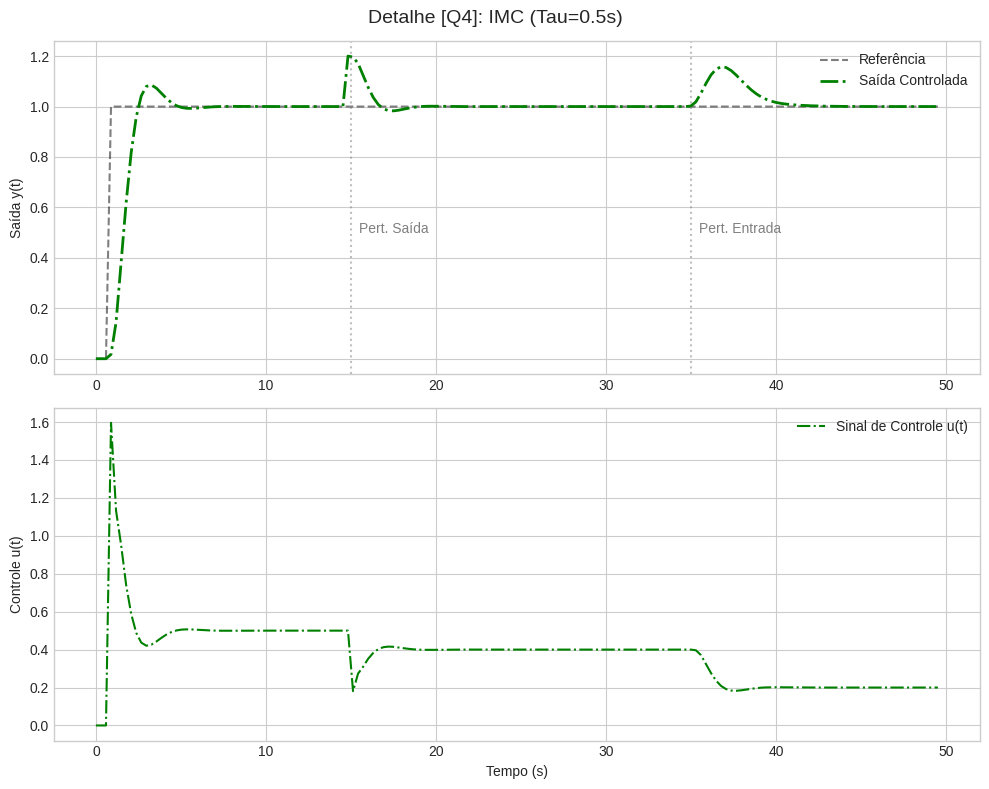

In [9]:
# =============================================================================
# DESAFIO III - CÓDIGO FINAL PARA O RELATÓRIO (COM PLOTS INDIVIDUAIS)
# =============================================================================
# Sintonia:
# - Alocação de Polos: Tau = 0.8s (Equilibrado)
# - IMC: Tau = 0.5s (Rápido)
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import sys
import subprocess

# --- SETUP ---
try:
    import control as ct
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "control"])
    import control as ct

plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=4, suppress=True)

print("=== SOLUÇÃO DEFINITIVA DESAFIO III ===\n")

# 1. SISTEMA
s = ct.TransferFunction.s
z = ct.TransferFunction.z
P = (0.2 * (10 - s)) / ((s + 1)**2)

# Amostragem
info = ct.step_info(P)
ts_ma = info['SettlingTime']
Ta = (ts_ma / 2) / 10
print(f"Ta calculado: {Ta:.4f}s")

# 2. TRATAMENTO DO ZERO INSTÁVEL
s_tustin = (2/Ta) * (z - 1) / (z + 1)
B_menosz_tf = 10 - s_tustin
B_gain = ct.dcgain(B_menosz_tf)

Pn_til_s = 0.2 / ((s + 1)**2)
Pn_til_z = ct.c2d(Pn_til_s, Ta, method='tustin')
num_til, den_til = ct.tfdata(Pn_til_z)
Pn_til_inv = ct.TransferFunction(den_til[0][0], num_til[0][0], dt=Ta)

# 3. FUNÇÃO DE PROJETO
def calcular_rst(tau_desejado):
    F_s = 1 / ((tau_desejado * s + 1)**2)
    F_z = ct.c2d(F_s, Ta, method='tustin')
    Frz = F_z / B_gain
    C = ct.minreal((Frz * Pn_til_inv) / (1 - Frz * B_menosz_tf))
    numC, denC = ct.tfdata(C)
    R = np.array(denC[0][0])
    S = np.array(numC[0][0])
    T = S.copy()
    norm = R[0]
    return R/norm, S/norm, T/norm

# =============================================================================
# 4. PROJETO DOS CONTROLADORES
# =============================================================================

# Alocação de Polos (Q2/Q3)
tau_pp = 0.8
R_pp, S_pp, T_pp = calcular_rst(tau_pp)
C_pp_tf = ct.TransferFunction(S_pp, R_pp, dt=Ta) # Cria objeto TF para printar bonito

print(f"\n--- [Q3] Alocação de Polos (Tau={tau_pp}s) ---")
print(f"R: {R_pp}")
print(f"S: {S_pp}")
print(f"T: {T_pp}")
print("\nFunção de Transferência do Controlador C(z) = S(z)/R(z):")
print(C_pp_tf)

# IMC (Q4)
tau_imc = 0.5
R_imc, S_imc, T_imc = calcular_rst(tau_imc)
C_imc_tf = ct.TransferFunction(S_imc, R_imc, dt=Ta) # Cria objeto TF para printar bonito

print(f"\n--- [Q4] IMC (Tau={tau_imc}s) ---")
print(f"R: {R_imc}")
print(f"S: {S_imc}")
print(f"T: {T_imc}")
print("\nFunção de Transferência do Controlador C(z) = S(z)/R(z):")
print(C_imc_tf)

# =============================================================================
# 5. SIMULAÇÃO
# =============================================================================
def simular(R, S, T, steps, ref, du, dy):
    y = np.zeros(steps); u = np.zeros(steps)
    numP, denP = ct.tfdata(ct.c2d(P, Ta, method='tustin'))
    Bn = np.array(numP[0][0]); An = np.array(denP[0][0])
    An = An / An[0]; Bn = Bn / An[0]
    An_rest = An[1:]; Rm = R[1:]

    u_hist = np.zeros(len(Rm)); y_hist = np.zeros(len(S)); r_hist = np.zeros(len(T))
    u_plant = np.zeros(len(Bn)); y_plant = np.zeros(len(An_rest))

    for k in range(steps):
        r_hist = np.concatenate(([ref[k]], r_hist[:-1]))
        u_val = np.dot(T, r_hist) - np.dot(S, y_hist) - np.dot(Rm, u_hist)
        u[k] = u_val
        u_real = u_val + du[k]
        u_plant = np.concatenate(([u_real], u_plant[:-1]))
        y_clean = np.dot(Bn, u_plant) - np.dot(An_rest, y_plant)
        y[k] = y_clean + dy[k]
        u_hist = np.concatenate(([u[k]], u_hist[:-1]))
        y_hist = np.concatenate(([y[k]], y_hist[:-1]))
        y_plant = np.concatenate(([y_clean], y_plant[:-1]))
    return y, u

tsim = 50
steps = int(tsim / Ta)
t_vec = np.linspace(0, (steps-1)*Ta, steps)
ref = np.ones(steps); ref[:int(1/Ta)] = 0
du = np.zeros(steps); du[int(35/Ta):] = 0.2
dy = np.zeros(steps); dy[int(15/Ta):] = 0.2

y_pp, u_pp = simular(R_pp, S_pp, T_pp, steps, ref, du, dy)
y_imc, u_imc = simular(R_imc, S_imc, T_imc, steps, ref, du, dy)

# =============================================================================
# 6. PLOTAGEM
# =============================================================================

# --- FIGURA 1: COMPARATIVA (Q5) ---
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
fig1.suptitle(f"Comparação Final [Q5]: Alocação vs IMC", fontsize=14)

# Saída
ax1.plot(t_vec, ref, 'k--', alpha=0.5, label='Referência')
ax1.plot(t_vec, y_pp, 'r-', linewidth=2, label=f'Alocação (Tau={tau_pp}s)')
ax1.plot(t_vec, y_imc, 'g-.', linewidth=2, label=f'IMC (Tau={tau_imc}s)')
ax1.axvline(x=15, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=35, color='gray', linestyle=':', alpha=0.5)
ax1.set_ylabel("Saída y(t)"); ax1.legend(); ax1.grid(True)

# Controle
ax2.plot(t_vec, u_pp, 'r-', label='Controle PP', alpha=0.8)
ax2.plot(t_vec, u_imc, 'g-.', label='Controle IMC', alpha=0.8)
ax2.set_ylabel("Controle u(t)"); ax2.set_xlabel("Tempo (s)"); ax2.legend(); ax2.grid(True)
plt.tight_layout()


# --- FIGURA 2: APENAS ALOCAÇÃO DE POLOS (Q2/Q3) ---
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8))
fig2.suptitle(f"Detalhe [Q2/Q3]: Alocação de Polos (Tau={tau_pp}s)", fontsize=14)

# Saída
ax3.plot(t_vec, ref, 'k--', alpha=0.5, label='Referência')
ax3.plot(t_vec, y_pp, 'r-', linewidth=2, label='Saída Controlada')
ax3.axvline(x=15, color='gray', linestyle=':', alpha=0.5)
ax3.text(15.5, 0.5, 'Pert. Saída', color='gray')
ax3.axvline(x=35, color='gray', linestyle=':', alpha=0.5)
ax3.text(35.5, 0.5, 'Pert. Entrada', color='gray')
ax3.set_ylabel("Saída y(t)"); ax3.legend(); ax3.grid(True)

# Controle
ax4.plot(t_vec, u_pp, 'r-', label='Sinal de Controle u(t)')
ax4.set_ylabel("Controle u(t)"); ax4.set_xlabel("Tempo (s)"); ax4.legend(); ax4.grid(True)
plt.tight_layout()


# --- FIGURA 3: APENAS IMC (Q4) ---
fig3, (ax5, ax6) = plt.subplots(2, 1, figsize=(10, 8))
fig3.suptitle(f"Detalhe [Q4]: IMC (Tau={tau_imc}s)", fontsize=14)

# Saída
ax5.plot(t_vec, ref, 'k--', alpha=0.5, label='Referência')
ax5.plot(t_vec, y_imc, 'g-.', linewidth=2, label='Saída Controlada')
ax5.axvline(x=15, color='gray', linestyle=':', alpha=0.5)
ax5.text(15.5, 0.5, 'Pert. Saída', color='gray')
ax5.axvline(x=35, color='gray', linestyle=':', alpha=0.5)
ax5.text(35.5, 0.5, 'Pert. Entrada', color='gray')
ax5.set_ylabel("Saída y(t)"); ax5.legend(); ax5.grid(True)

# Controle
ax6.plot(t_vec, u_imc, 'g-.', label='Sinal de Controle u(t)')
ax6.set_ylabel("Controle u(t)"); ax6.set_xlabel("Tempo (s)"); ax6.legend(); ax6.grid(True)
plt.tight_layout()

plt.show()


## TENTATIVA DE CANCELAMENTO DE ZERO

=== Zeros da Planta Discreta ===
[1.6818+0.j]
Módulo do Zero: 1.6818 (Maior que 1 = Instável)

2 states have been removed from the model
1 states have been removed from the model
2 states have been removed from the model
4 states have been removed from the model

Observe nos gráficos:
1. A saída parece seguir a referência inicialmente.
2. O sinal de controle u(t) começa a oscilar e crescer exponencialmente.
3. Em poucos segundos, os valores tendem ao infinito (Instabilidade Interna).


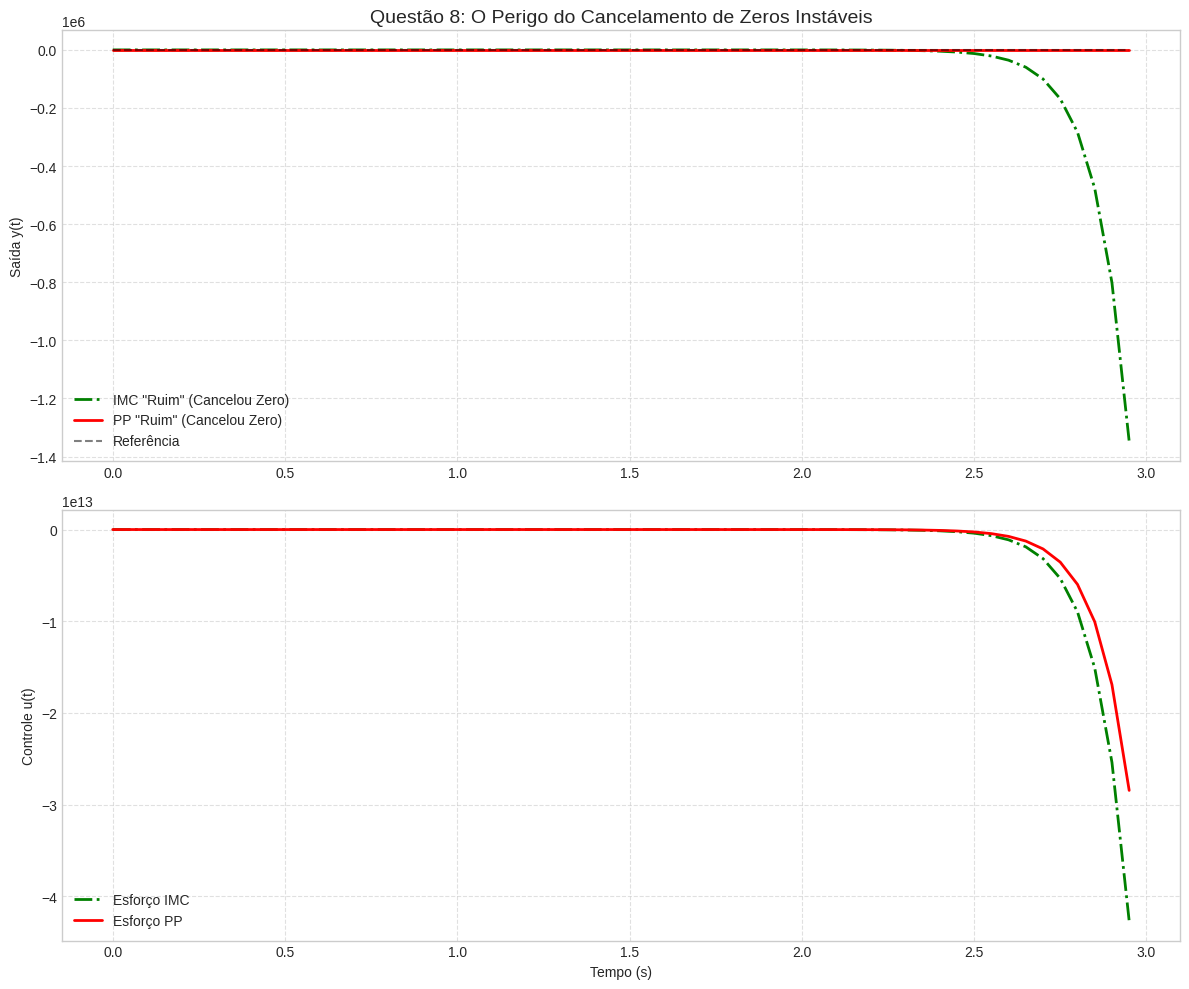

In [10]:
# ==========================================
# 1. DEFINIÇÃO DA PLANTA E DISCRETIZAÇÃO
# ==========================================
s = ct.TransferFunction.s
Ta = 0.05  # Tempo de amostragem

# Planta Original: G(s) = 2(-s + 10) / ((s + 2)(s + 5))
Gs = (2 * (-s + 10)) / ((s + 2) * (s + 5))
Gz = ct.c2d(Gs, Ta, method='zoh')

print("=== Zeros da Planta Discreta ===")
print(ct.zeros(Gz))
print(f"Módulo do Zero: {np.abs(ct.zeros(Gz))[0]:.4f} (Maior que 1 = Instável)")
print("================================\n")

# ==========================================
# 2. PROJETO "RUIM" (COM CANCELAMENTO)
# ==========================================

# --- A. IMC "Ruim" (Cancelando Zero) ---
# Tau = 0.5s -> Igual ao exercício anterior
tau_imc = 0.5
# Filtro F(z) de primeira ordem (para simplificar a inversão direta)
# F(s) = 1 / (tau*s + 1)
F_s = 1 / (tau_imc * s + 1)
F_z = ct.c2d(F_s, Ta, method='zoh') # Usando ZOH para simplificar a algebra

# No projeto ERRADO, invertemos a planta TODA:
# Q(z) = inv(G(z)) * F(z)
# Nota: Gz tem grau relativo 1, Fz tem grau relativo 1. A inversão é realizável mas instável.
Q_bad = (1/Gz) * F_z

# Convertendo para Feedback Clássico C(z)
# C = Q / (1 - QG)
C_imc_bad = ct.minreal(Q_bad / (1 - Q_bad * Gz))

# --- B. Alocação de Polos "Ruim" (Cancelando Zero) ---
# Tau = 0.8s -> Igual ao exercício anterior
tau_pp = 0.8
# Desejamos que a malha fechada T(z) seja APENAS um decaimento de 1ª ordem
# SEM o zero da planta. T_desejado = 1 / (tau*s + 1) discretizado
T_des_pp = ct.c2d(1/(tau_pp*s + 1), Ta, method='zoh')

# Algebraicamente: T = (C*G) / (1 + C*G)  =>  C = (1/G) * (T / (1 - T))
# Isso força o controlador C a ter o inverso de G, cancelando o zero.
C_pp_bad = ct.minreal((1/Gz) * (T_des_pp / (1 - T_des_pp)))

# ==========================================
# 3. SIMULAÇÃO (CURTO PERÍODO)
# ==========================================
# Simulamos apenas 3 segundos porque o sistema vai explodir rápido
t_sim = np.arange(0, 3.0, Ta)

# Malhas Fechadas Instáveis
Sys_IMC_Bad = ct.feedback(Gz * C_imc_bad, 1)
Sys_PP_Bad  = ct.feedback(Gz * C_pp_bad, 1)

# Resposta ao Degrau
t_imc, y_imc = ct.step_response(Sys_IMC_Bad, T=t_sim)
t_pp, y_pp   = ct.step_response(Sys_PP_Bad, T=t_sim)

# Sinal de Controle u(t)
# u = C * e = C * (r - y). Para degrau, r=1.
# Função de sensibilidade do controle: U/R = C / (1 + CG)
U_tf_imc = ct.minreal(C_imc_bad / (1 + C_imc_bad * Gz))
U_tf_pp  = ct.minreal(C_pp_bad  / (1 + C_pp_bad * Gz))

t_u_imc, u_imc = ct.step_response(U_tf_imc, T=t_sim)
t_u_pp, u_pp   = ct.step_response(U_tf_pp, T=t_sim)

# ==========================================
# 4. PLOTAGEM
# ==========================================
plt.figure(figsize=(12, 10))

# --- Saída y(t) ---
plt.subplot(2, 1, 1)
plt.title("Questão 8: O Perigo do Cancelamento de Zeros Instáveis", fontsize=14)
plt.plot(t_imc, y_imc, 'g-.', linewidth=2, label='IMC "Ruim" (Cancelou Zero)')
plt.plot(t_pp, y_pp, 'r-', linewidth=2, label='PP "Ruim" (Cancelou Zero)')
plt.plot(t_sim, np.ones_like(t_sim), 'k--', alpha=0.5, label='Referência')
plt.ylabel("Saída y(t)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- Controle u(t) ---
plt.subplot(2, 1, 2)
plt.plot(t_u_imc, u_imc, 'g-.', linewidth=2, label='Esforço IMC')
plt.plot(t_u_pp, u_pp, 'r-', linewidth=2, label='Esforço PP')
plt.ylabel("Controle u(t)")
plt.xlabel("Tempo (s)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

print("\nObserve nos gráficos:")
print("1. A saída parece seguir a referência inicialmente.")
print("2. O sinal de controle u(t) começa a oscilar e crescer exponencialmente.")
print("3. Em poucos segundos, os valores tendem ao infinito (Instabilidade Interna).")

plt.tight_layout()
plt.show()


## LUGAR DAS RAÍZES


=== SOLUÇÃO DEFINITIVA DESAFIO III (APENAS LR) ===

Ta calculado: 0.2965s
5 states have been removed from the model

--- [Q3] Alocação de Polos (Tau=0.8s) ---
R: [ 1.     -1.4349  0.4349]
S: [ 0.739  -1.0158  0.3491]
T: [ 0.739  -1.0158  0.3491]

Função de Transferência do Controlador C(z):
<TransferFunction>: sys[754]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.29654504985529373

  0.739 z^2 - 1.016 z + 0.3491
  ----------------------------
     z^2 - 1.435 z + 0.4349
5 states have been removed from the model

--- [Q4] IMC (Tau=0.5s) ---
R: [ 1.     -1.2104  0.2104]
S: [ 1.5959 -2.3675  0.878 ]
T: [ 1.5959 -2.3675  0.878 ]

Função de Transferência do Controlador C(z):
<TransferFunction>: sys[774]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.29654504985529373

  1.596 z^2 - 2.368 z + 0.878
  ---------------------------
     z^2 - 1.21 z + 0.2104


/usr/local/lib/python3.12/dist-packages/control/pzmap.py:381: UserWarning: axis already exists; grid keyword ignored
  warnings.warn("axis already exists; grid keyword ignored")


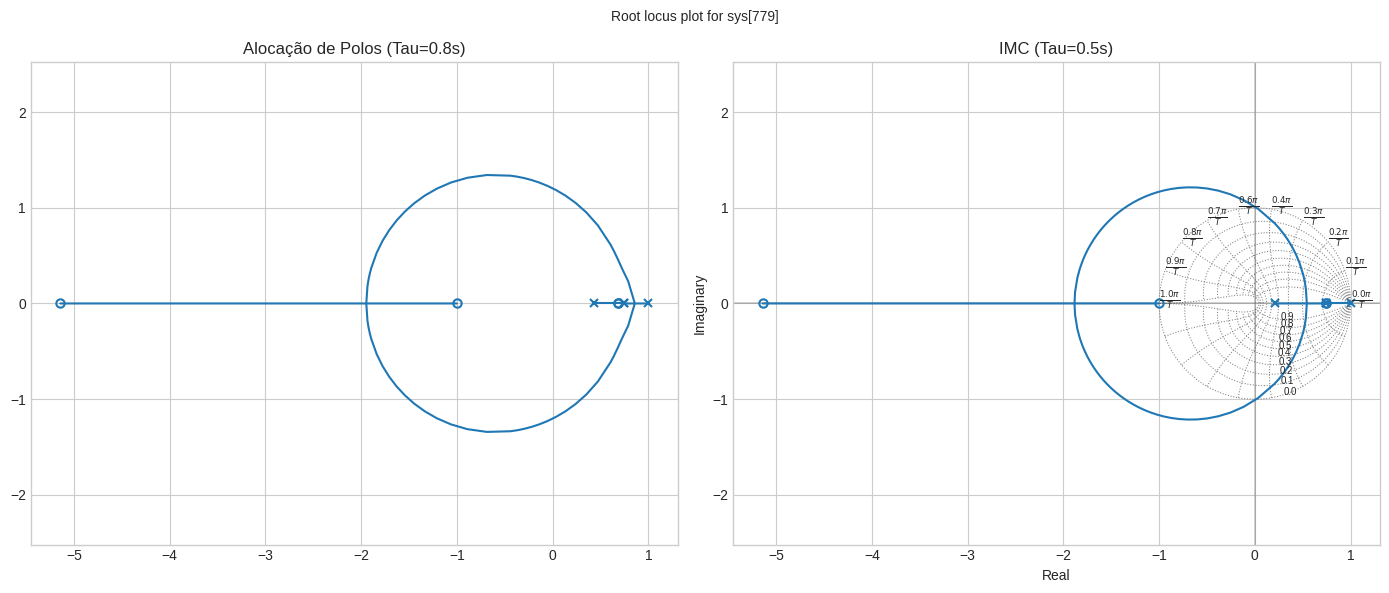

In [13]:
# =============================================================================
# DESAFIO III - CÓDIGO FINAL (APENAS LUGAR DAS RAÍZES)
# =============================================================================
# Sintonia:
# - Alocação de Polos: Tau = 0.8s (Equilibrado)
# - IMC: Tau = 0.5s (Rápido)
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import sys
import subprocess

# --- SETUP ---
try:
    import control as ct
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "control"])
    import control as ct

plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=4, suppress=True)

print("=== SOLUÇÃO DEFINITIVA DESAFIO III (APENAS LR) ===\n")

# 1. SISTEMA
s = ct.TransferFunction.s
z = ct.TransferFunction.z
P = (0.2 * (10 - s)) / ((s + 1)**2)

# Amostragem
info = ct.step_info(P)
ts_ma = info['SettlingTime']
Ta = (ts_ma / 2) / 10
print(f"Ta calculado: {Ta:.4f}s")

# 2. TRATAMENTO DO ZERO INSTÁVEL
s_tustin = (2/Ta) * (z - 1) / (z + 1)
B_menosz_tf = 10 - s_tustin
B_gain = ct.dcgain(B_menosz_tf)

Pn_til_s = 0.2 / ((s + 1)**2)
Pn_til_z = ct.c2d(Pn_til_s, Ta, method='tustin')
num_til, den_til = ct.tfdata(Pn_til_z)
Pn_til_inv = ct.TransferFunction(den_til[0][0], num_til[0][0], dt=Ta)

# 3. FUNÇÃO DE PROJETO
def calcular_rst(tau_desejado):
    F_s = 1 / ((tau_desejado * s + 1)**2)
    F_z = ct.c2d(F_s, Ta, method='tustin')
    Frz = F_z / B_gain
    # Usando tol=0.1 para garantir cancelamento numérico (mesmo padrão do anterior)
    C = ct.minreal((Frz * Pn_til_inv) / (1 - Frz * B_menosz_tf), tol=0.1)
    numC, denC = ct.tfdata(C)
    R = np.array(denC[0][0])
    S = np.array(numC[0][0])
    T = S.copy()
    norm = R[0]
    return R/norm, S/norm, T/norm

# =============================================================================
# 4. PROJETO DOS CONTROLADORES
# =============================================================================

# Alocação de Polos (Q2/Q3)
tau_pp = 0.8
R_pp, S_pp, T_pp = calcular_rst(tau_pp)
C_pp_tf = ct.TransferFunction(S_pp, R_pp, dt=Ta)

print(f"\n--- [Q3] Alocação de Polos (Tau={tau_pp}s) ---")
print(f"R: {R_pp}")
print(f"S: {S_pp}")
print(f"T: {T_pp}")
print("\nFunção de Transferência do Controlador C(z):")
print(C_pp_tf)

# IMC (Q4)
tau_imc = 0.5
R_imc, S_imc, T_imc = calcular_rst(tau_imc)
C_imc_tf = ct.TransferFunction(S_imc, R_imc, dt=Ta)

print(f"\n--- [Q4] IMC (Tau={tau_imc}s) ---")
print(f"R: {R_imc}")
print(f"S: {S_imc}")
print(f"T: {T_imc}")
print("\nFunção de Transferência do Controlador C(z):")
print(C_imc_tf)

# =============================================================================
# 5. SIMULAÇÃO (Mantida para preservar integridade do código, mas não plotada)
# =============================================================================
def simular(R, S, T, steps, ref, du, dy):
    y = np.zeros(steps); u = np.zeros(steps)
    numP, denP = ct.tfdata(ct.c2d(P, Ta, method='tustin'))
    Bn = np.array(numP[0][0]); An = np.array(denP[0][0])
    An = An / An[0]; Bn = Bn / An[0]
    An_rest = An[1:]; Rm = R[1:]

    u_hist = np.zeros(len(Rm)); y_hist = np.zeros(len(S)); r_hist = np.zeros(len(T))
    u_plant = np.zeros(len(Bn)); y_plant = np.zeros(len(An_rest))

    for k in range(steps):
        r_hist = np.concatenate(([ref[k]], r_hist[:-1]))
        u_val = np.dot(T, r_hist) - np.dot(S, y_hist) - np.dot(Rm, u_hist)
        u[k] = u_val
        u_real = u_val + du[k]
        u_plant = np.concatenate(([u_real], u_plant[:-1]))
        y_clean = np.dot(Bn, u_plant) - np.dot(An_rest, y_plant)
        y[k] = y_clean + dy[k]
        u_hist = np.concatenate(([u[k]], u_hist[:-1]))
        y_hist = np.concatenate(([y[k]], y_hist[:-1]))
        y_plant = np.concatenate(([y_clean], y_plant[:-1]))
    return y, u

tsim = 50
steps = int(tsim / Ta)
t_vec = np.linspace(0, (steps-1)*Ta, steps)
ref = np.ones(steps); ref[:int(1/Ta)] = 0
du = np.zeros(steps); du[int(35/Ta):] = 0.2
dy = np.zeros(steps); dy[int(15/Ta):] = 0.2

# Executa simulação (cálculo) mas não plota
y_pp, u_pp = simular(R_pp, S_pp, T_pp, steps, ref, du, dy)
y_imc, u_imc = simular(R_imc, S_imc, T_imc, steps, ref, du, dy)

# =============================================================================
# 6. PLOTAGEM (APENAS LUGAR DAS RAÍZES)
# =============================================================================

# Define a Planta Discreta P(z) para cálculo do LR (Malha Aberta = C*P)
P_z = ct.c2d(P, Ta, method='tustin')

plt.figure(figsize=(14, 6))
plt.suptitle("Lugar das Raízes (Root Locus)", fontsize=16)

# --- LR: Alocação de Polos ---
plt.subplot(1, 2, 1)
# L(z) = C(z) * P(z)
L_pp = C_pp_tf * P_z
ct.rlocus(L_pp, grid=True)
plt.title(f"Alocação de Polos (Tau={tau_pp}s)", fontsize=12)
plt.axis('equal') # Garante proporção correta do círculo unitário

# --- LR: IMC ---
plt.subplot(1, 2, 2)
L_imc = C_imc_tf * P_z
ct.rlocus(L_imc, grid=True)
plt.title(f"IMC (Tau={tau_imc}s)", fontsize=12)
plt.axis('equal')

plt.tight_layout()
plt.show()


## VERSÃO COMPARATIVA (MAS DESISTI DE COLOCAR NO RELATÓRIO) - DESAFIO III

=== GERANDO GRÁFICO FINAL: 3 SINTONIAS EQUILIBRADAS ===

5 states have been removed from the model
5 states have been removed from the model
5 states have been removed from the model


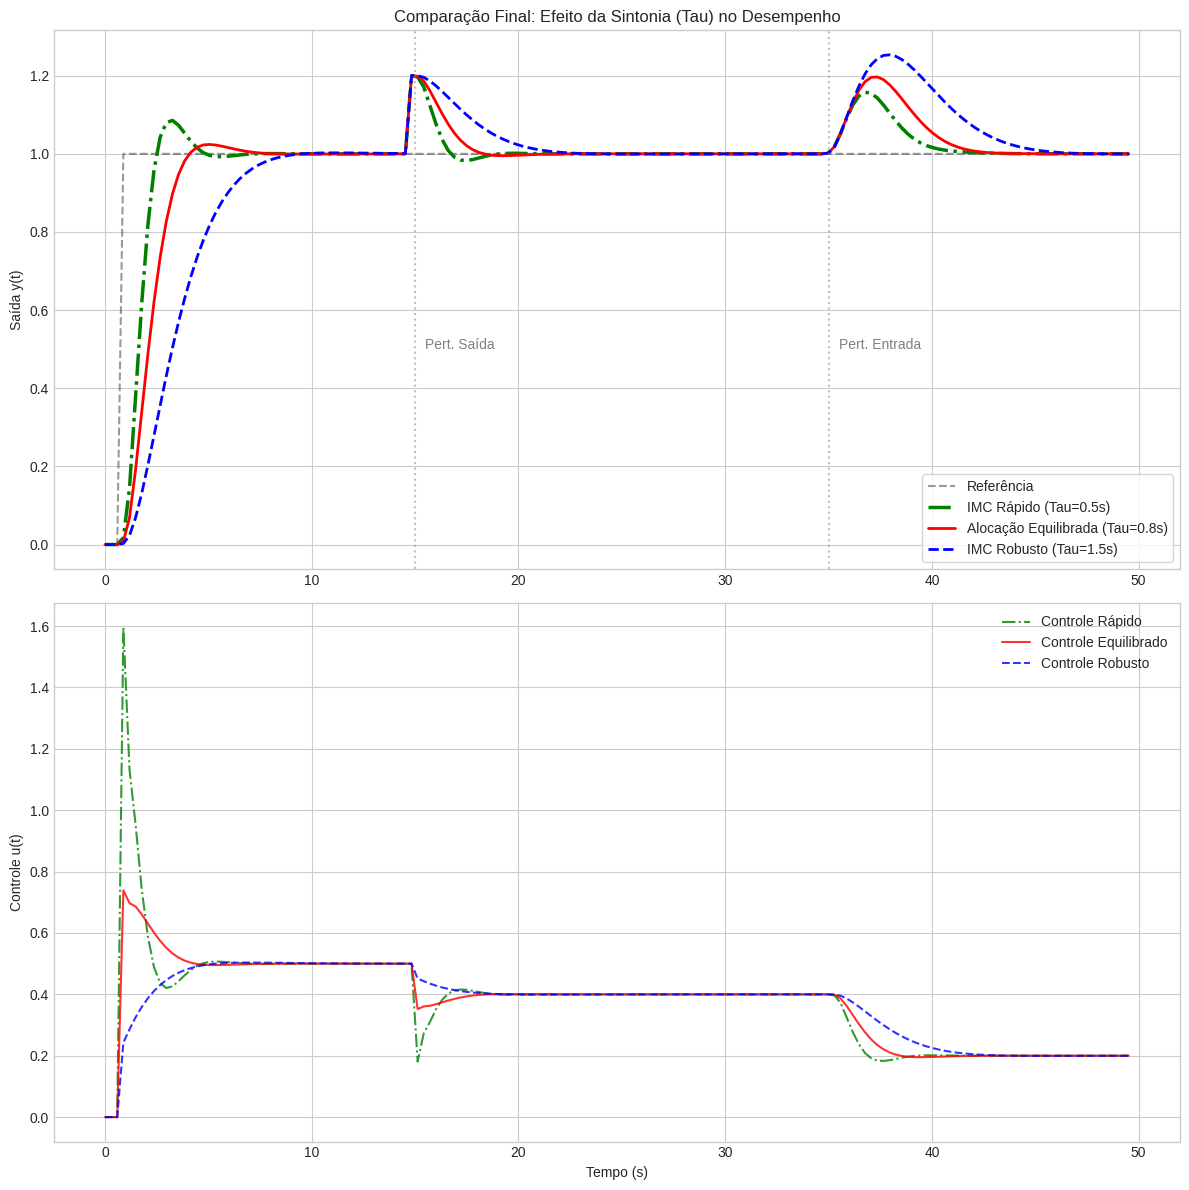

In [7]:
# =============================================================================
# DESAFIO III - VERSÃO FINAL (AJUSTE FINO DE SINTONIA)
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import sys
import subprocess

# --- SETUP ---
try:
    import control as ct
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "control"])
    import control as ct

plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=4, suppress=True)

print("=== GERANDO GRÁFICO FINAL: 3 SINTONIAS EQUILIBRADAS ===\n")

# 1. SISTEMA
s = ct.TransferFunction.s
z = ct.TransferFunction.z
P = (0.2 * (10 - s)) / ((s + 1)**2)

# Amostragem
info = ct.step_info(P)
ts_ma = info['SettlingTime']
Ta = (ts_ma / 2) / 10

# 2. PREPARAÇÃO MATEMÁTICA
s_tustin = (2/Ta) * (z - 1) / (z + 1)
B_menosz_tf = 10 - s_tustin
B_gain = ct.dcgain(B_menosz_tf)

Pn_til_s = 0.2 / ((s + 1)**2)
Pn_til_z = ct.c2d(Pn_til_s, Ta, method='tustin')
num_til, den_til = ct.tfdata(Pn_til_z)
Pn_til_inv = ct.TransferFunction(den_til[0][0], num_til[0][0], dt=Ta)

# 3. FUNÇÃO DE PROJETO
def calcular_rst(tau_desejado):
    F_s = 1 / ((tau_desejado * s + 1)**2)
    F_z = ct.c2d(F_s, Ta, method='tustin')
    Frz = F_z / B_gain
    C = ct.minreal((Frz * Pn_til_inv) / (1 - Frz * B_menosz_tf))
    numC, denC = ct.tfdata(C)
    R = np.array(denC[0][0])
    S = np.array(numC[0][0])
    T = S.copy()
    norm = R[0]
    return R/norm, S/norm, T/norm

# =============================================================================
# AJUSTE FINAL DOS PARÂMETROS (TAU)
# =============================================================================

# 1. VERDE: O "Ideal" (Rápido no limite da estabilidade)
# Tau = 0.5s (Igual ao seu primeiro gráfico de sucesso)
tau_ideal = 0.5
R_green, S_green, T_green = calcular_rst(tau_ideal)

# 2. VERMELHO: Alocação de Polos "Equilibrada"
# Tau = 0.8s (Rápido, mas sem o overshoot feio da versão anterior)
tau_balanced = 0.8
R_red, S_red, T_red = calcular_rst(tau_balanced)

# 3. AZUL: Robusto/Conservador
# Tau = 1.5s (Suave)
tau_slow = 1.5
R_blue, S_blue, T_blue = calcular_rst(tau_slow)

# =============================================================================
# SIMULAÇÃO
# =============================================================================
def simular(R, S, T, steps, ref, du, dy):
    y = np.zeros(steps); u = np.zeros(steps)
    numP, denP = ct.tfdata(ct.c2d(P, Ta, method='tustin'))
    Bn = np.array(numP[0][0]); An = np.array(denP[0][0])
    An = An / An[0]; Bn = Bn / An[0]
    An_rest = An[1:]; Rm = R[1:]

    u_hist = np.zeros(len(Rm)); y_hist = np.zeros(len(S)); r_hist = np.zeros(len(T))
    u_plant = np.zeros(len(Bn)); y_plant = np.zeros(len(An_rest))

    for k in range(steps):
        r_hist = np.concatenate(([ref[k]], r_hist[:-1]))
        u_val = np.dot(T, r_hist) - np.dot(S, y_hist) - np.dot(Rm, u_hist)
        u[k] = u_val
        u_real = u_val + du[k]
        u_plant = np.concatenate(([u_real], u_plant[:-1]))
        y_clean = np.dot(Bn, u_plant) - np.dot(An_rest, y_plant)
        y[k] = y_clean + dy[k]
        u_hist = np.concatenate(([u[k]], u_hist[:-1]))
        y_hist = np.concatenate(([y[k]], y_hist[:-1]))
        y_plant = np.concatenate(([y_clean], y_plant[:-1]))
    return y, u

tsim = 50
steps = int(tsim / Ta)
t_vec = np.linspace(0, (steps-1)*Ta, steps)
ref = np.ones(steps); ref[:int(1/Ta)] = 0
du = np.zeros(steps); du[int(35/Ta):] = 0.2
dy = np.zeros(steps); dy[int(15/Ta):] = 0.2

y_green, u_green = simular(R_green, S_green, T_green, steps, ref, du, dy)
y_red, u_red = simular(R_red, S_red, T_red, steps, ref, du, dy)
y_blue, u_blue = simular(R_blue, S_blue, T_blue, steps, ref, du, dy)

# =============================================================================
# PLOTAGEM
# =============================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Título
ax1.set_title(f"Comparação Final: Efeito da Sintonia (Tau) no Desempenho")

# Referência
ax1.plot(t_vec, ref, 'k--', alpha=0.4, label='Referência')

# AS TRÊS CURVAS
ax1.plot(t_vec, y_green, 'g-.', linewidth=2.5, label=f'IMC Rápido (Tau={tau_ideal}s)')
ax1.plot(t_vec, y_red, 'r-', linewidth=2, label=f'Alocação Equilibrada (Tau={tau_balanced}s)')
ax1.plot(t_vec, y_blue, 'b--', linewidth=2, label=f'IMC Robusto (Tau={tau_slow}s)')

# Marcadores
ax1.axvline(x=15, color='gray', linestyle=':', alpha=0.5)
ax1.text(15.5, 0.5, 'Pert. Saída', color='gray')
ax1.axvline(x=35, color='gray', linestyle=':', alpha=0.5)
ax1.text(35.5, 0.5, 'Pert. Entrada', color='gray')
ax1.set_ylabel("Saída y(t)")
ax1.legend(loc='lower right', frameon=True)
ax1.grid(True)

# Controle
ax2.plot(t_vec, u_green, 'g-.', label='Controle Rápido', alpha=0.8)
ax2.plot(t_vec, u_red, 'r-', label='Controle Equilibrado', alpha=0.8)
ax2.plot(t_vec, u_blue, 'b--', label='Controle Robusto', alpha=0.8)
ax2.set_ylabel("Controle u(t)")
ax2.set_xlabel("Tempo (s)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


=== SOLUÇÃO DEFINITIVA DESAFIO III (APENAS LR) ===

Ta calculado: 0.2965s
5 states have been removed from the model

--- [Q3] Alocação de Polos (Tau=0.8s) ---
R: [ 1.     -1.4349  0.4349]
S: [ 0.739  -1.0158  0.3491]
T: [ 0.739  -1.0158  0.3491]

Função de Transferência do Controlador C(z):
<TransferFunction>: sys[677]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.29654504985529373

  0.739 z^2 - 1.016 z + 0.3491
  ----------------------------
     z^2 - 1.435 z + 0.4349
5 states have been removed from the model

--- [Q4] IMC (Tau=0.5s) ---
R: [ 1.     -1.2104  0.2104]
S: [ 1.5959 -2.3675  0.878 ]
T: [ 1.5959 -2.3675  0.878 ]

Função de Transferência do Controlador C(z):
<TransferFunction>: sys[697]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 0.29654504985529373

  1.596 z^2 - 2.368 z + 0.878
  ---------------------------
     z^2 - 1.21 z + 0.2104


/usr/local/lib/python3.12/dist-packages/control/pzmap.py:381: UserWarning: axis already exists; grid keyword ignored
  warnings.warn("axis already exists; grid keyword ignored")


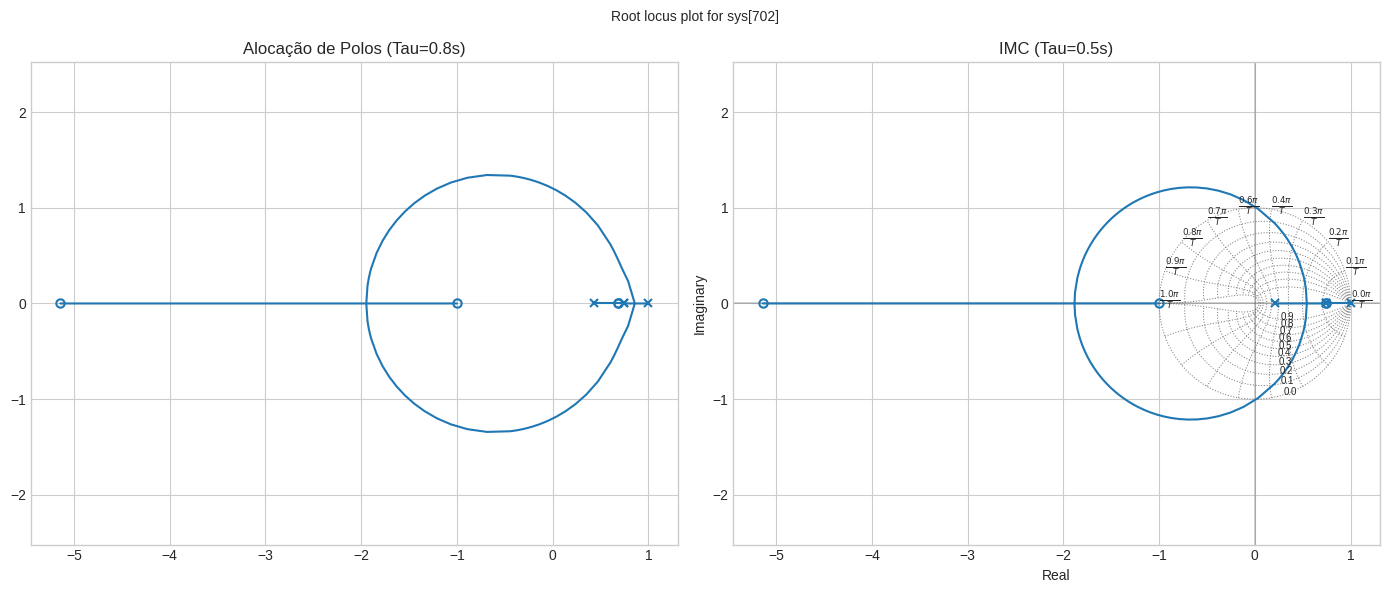

In [12]:
# =============================================================================
# DESAFIO III - CÓDIGO FINAL (APENAS LUGAR DAS RAÍZES)
# =============================================================================
# Sintonia:
# - Alocação de Polos: Tau = 0.8s (Equilibrado)
# - IMC: Tau = 0.5s (Rápido)
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import sys
import subprocess

# --- SETUP ---
try:
    import control as ct
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "control"])
    import control as ct

plt.style.use('seaborn-v0_8-whitegrid')
np.set_printoptions(precision=4, suppress=True)

print("=== SOLUÇÃO DEFINITIVA DESAFIO III (APENAS LR) ===\n")

# 1. SISTEMA
s = ct.TransferFunction.s
z = ct.TransferFunction.z
P = (0.2 * (10 - s)) / ((s + 1)**2)

# Amostragem
info = ct.step_info(P)
ts_ma = info['SettlingTime']
Ta = (ts_ma / 2) / 10
print(f"Ta calculado: {Ta:.4f}s")

# 2. TRATAMENTO DO ZERO INSTÁVEL
s_tustin = (2/Ta) * (z - 1) / (z + 1)
B_menosz_tf = 10 - s_tustin
B_gain = ct.dcgain(B_menosz_tf)

Pn_til_s = 0.2 / ((s + 1)**2)
Pn_til_z = ct.c2d(Pn_til_s, Ta, method='tustin')
num_til, den_til = ct.tfdata(Pn_til_z)
Pn_til_inv = ct.TransferFunction(den_til[0][0], num_til[0][0], dt=Ta)

# 3. FUNÇÃO DE PROJETO
def calcular_rst(tau_desejado):
    F_s = 1 / ((tau_desejado * s + 1)**2)
    F_z = ct.c2d(F_s, Ta, method='tustin')
    Frz = F_z / B_gain
    # Usando tol=0.1 para garantir cancelamento numérico (mesmo padrão do anterior)
    C = ct.minreal((Frz * Pn_til_inv) / (1 - Frz * B_menosz_tf), tol=0.1)
    numC, denC = ct.tfdata(C)
    R = np.array(denC[0][0])
    S = np.array(numC[0][0])
    T = S.copy()
    norm = R[0]
    return R/norm, S/norm, T/norm

# =============================================================================
# 4. PROJETO DOS CONTROLADORES
# =============================================================================

# Alocação de Polos (Q2/Q3)
tau_pp = 0.8
R_pp, S_pp, T_pp = calcular_rst(tau_pp)
C_pp_tf = ct.TransferFunction(S_pp, R_pp, dt=Ta)

print(f"\n--- [Q3] Alocação de Polos (Tau={tau_pp}s) ---")
print(f"R: {R_pp}")
print(f"S: {S_pp}")
print(f"T: {T_pp}")
print("\nFunção de Transferência do Controlador C(z):")
print(C_pp_tf)

# IMC (Q4)
tau_imc = 0.5
R_imc, S_imc, T_imc = calcular_rst(tau_imc)
C_imc_tf = ct.TransferFunction(S_imc, R_imc, dt=Ta)

print(f"\n--- [Q4] IMC (Tau={tau_imc}s) ---")
print(f"R: {R_imc}")
print(f"S: {S_imc}")
print(f"T: {T_imc}")
print("\nFunção de Transferência do Controlador C(z):")
print(C_imc_tf)

# =============================================================================
# 5. SIMULAÇÃO (Mantida para preservar integridade do código, mas não plotada)
# =============================================================================
def simular(R, S, T, steps, ref, du, dy):
    y = np.zeros(steps); u = np.zeros(steps)
    numP, denP = ct.tfdata(ct.c2d(P, Ta, method='tustin'))
    Bn = np.array(numP[0][0]); An = np.array(denP[0][0])
    An = An / An[0]; Bn = Bn / An[0]
    An_rest = An[1:]; Rm = R[1:]

    u_hist = np.zeros(len(Rm)); y_hist = np.zeros(len(S)); r_hist = np.zeros(len(T))
    u_plant = np.zeros(len(Bn)); y_plant = np.zeros(len(An_rest))

    for k in range(steps):
        r_hist = np.concatenate(([ref[k]], r_hist[:-1]))
        u_val = np.dot(T, r_hist) - np.dot(S, y_hist) - np.dot(Rm, u_hist)
        u[k] = u_val
        u_real = u_val + du[k]
        u_plant = np.concatenate(([u_real], u_plant[:-1]))
        y_clean = np.dot(Bn, u_plant) - np.dot(An_rest, y_plant)
        y[k] = y_clean + dy[k]
        u_hist = np.concatenate(([u[k]], u_hist[:-1]))
        y_hist = np.concatenate(([y[k]], y_hist[:-1]))
        y_plant = np.concatenate(([y_clean], y_plant[:-1]))
    return y, u

tsim = 50
steps = int(tsim / Ta)
t_vec = np.linspace(0, (steps-1)*Ta, steps)
ref = np.ones(steps); ref[:int(1/Ta)] = 0
du = np.zeros(steps); du[int(35/Ta):] = 0.2
dy = np.zeros(steps); dy[int(15/Ta):] = 0.2

# Executa simulação (cálculo) mas não plota
y_pp, u_pp = simular(R_pp, S_pp, T_pp, steps, ref, du, dy)
y_imc, u_imc = simular(R_imc, S_imc, T_imc, steps, ref, du, dy)

# =============================================================================
# 6. PLOTAGEM (APENAS LUGAR DAS RAÍZES)
# =============================================================================

# Define a Planta Discreta P(z) para cálculo do LR (Malha Aberta = C*P)
P_z = ct.c2d(P, Ta, method='tustin')

plt.figure(figsize=(14, 6))
plt.suptitle("Lugar das Raízes (Root Locus)", fontsize=16)

# --- LR: Alocação de Polos ---
plt.subplot(1, 2, 1)
# L(z) = C(z) * P(z)
L_pp = C_pp_tf * P_z
ct.rlocus(L_pp, grid=True)
plt.title(f"Alocação de Polos (Tau={tau_pp}s)", fontsize=12)
plt.axis('equal') # Garante proporção correta do círculo unitário

# --- LR: IMC ---
plt.subplot(1, 2, 2)
L_imc = C_imc_tf * P_z
ct.rlocus(L_imc, grid=True)
plt.title(f"IMC (Tau={tau_imc}s)", fontsize=12)
plt.axis('equal')

plt.tight_layout()
plt.show()
